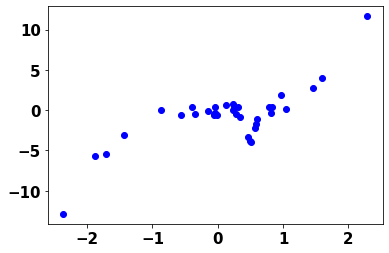

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import numpy as np

class Network(nn.Module):

  def __init__(self, inp_dim):
    super().__init__()
    self.fc1 = nn.Linear(inp_dim, 200)
    self.fc2 = nn.Linear(200,200)
    self.fc3 = nn.Linear(200, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x



lr = 1e-3 
momentum = 0.0 
batch_size = 1 
num_epochs = 200 


## Generate data
num_pts = 35
X = np.random.normal(0,0.9, num_pts)
Y = X**3 - 4*np.exp(-(X-0.5)**2/0.01) + np.random.normal(0, 0.5, num_pts)
X_true = np.linspace(-3,3.400)
Y_true = X_true**3 

plt.plot(X,Y, 'bo')


## Create training set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.02)
x_m = np.mean(X_train, axis = 0)
x_std = np.std(X_train, axis = 0)
y_m = np.mean(y_train)
y_std = np.std(y_train)

X_train = (X_train - x_m)/x_std
X_test = (X_test - x_m)/x_std
y_train = (y_train - y_m)/y_std 
y_test = (y_test - y_m)/y_std


X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float()

train_data = [(X_train_t[i].view(-1), y_train_t[i]) for i in range(X_train_t.shape[0])]
test_data = [(X_test_t[i].view(-1), y_test_t[i]) for i in range(X_test_t.shape[0])]

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000)

In [15]:

class monotoneLoss():

  ## Loss function to enforce monotonicity of the neural network

  def __init__(self, feature_inds, weight_lambda):

    ## Args:
      ## feature_inds: list with the indices of the features that should be monotone
      ## weight_lambda: The scaling factor for the loss

    self.monotone_feat = feature_inds 
    self.weight_lambda = weight_lambda

  def calc_loss(self, my_net, x):

    ## Args:
      ## my_net: The neural network
      ## x: The input points where the monotonicity should be enforced
    ## Assume that input x is of the shape (batch_size, num_features)

    ## Create boolean matrix to zero out derivatives for non-monotone features
    self.zero_t = torch.zeros([x.shape[0], x.shape[1]])
    self.zero_t[:, self.monotone_feat] = 1.
    
    x.requires_grad=True
    o = my_net(x)
    o = o.view(-1)

    dx = torch.autograd.grad(o, x, create_graph=True, grad_outputs = torch.ones(o.shape[0]))[0]
    
    dx = torch.clip(-dx*self.zero_t, min = 0)
    dxloss = torch.mean(dx)

    ## Calculate partial derivative for all parameters
    for idx,w in enumerate(my_net.parameters()):      
      dx_c = torch.clone(dxloss).view(-1)
      
      dxdw = torch.autograd.grad(dx_c, w, retain_graph = True,allow_unused=True, grad_outputs = torch.ones(dx_c.shape[0]))[0]
      
      
      if not dxdw is None and not w.grad is None:
        ## If we have already added something to the gradient
        w.grad = w.grad + self.weight_lambda*dxdw
      elif not dxdw is None:
        w.grad = self.weight_lambda*dxdw
      elif not w.grad is None:
        #w.grad = w.grad + torch.zeros_like(w)
        pass
      else:
        w.grad = torch.zeros_like(w)
      
    x.requires_grad = False


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Tot train loss: 0.9911489938265945 Tot test loss: 0.32773181796073914
Epoch: 1 Tot train loss: 0.7107395966321586 Tot test loss: 0.4600878357887268
Epoch: 2 Tot train loss: 0.5677494758582564 Tot test loss: 0.5684188604354858
Epoch: 3 Tot train loss: 0.5024557189522859 Tot test loss: 0.7587372660636902
Epoch: 4 Tot train loss: 0.45514939758269224 Tot test loss: 0.8850430846214294
Epoch: 5 Tot train loss: 0.423515114816837 Tot test loss: 1.0918340682983398
Epoch: 6 Tot train loss: 0.4031682808328482 Tot test loss: 1.1116697788238525
Epoch: 7 Tot train loss: 0.3841115509969634 Tot test loss: 1.004288911819458
Epoch: 8 Tot train loss: 0.37189027833279825 Tot test loss: 0.9943935871124268
Epoch: 9 Tot train loss: 0.36158303382955426 Tot test loss: 1.062888503074646
Epoch: 10 Tot train loss: 0.34506661557337365 Tot test loss: 0.999297022819519
Epoch: 11 Tot train loss: 0.33683357868614944 Tot test loss: 1.0715020895004272
Epoch: 12 Tot train loss: 0.320694679108248 Tot test loss: 1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Tot train loss: 0.8406568161376259 Tot test loss: 0.5147918462753296
Epoch: 1 Tot train loss: 0.6061230133451746 Tot test loss: 0.5585788488388062
Epoch: 2 Tot train loss: 0.4978374376745812 Tot test loss: 0.8090146780014038
Epoch: 3 Tot train loss: 0.437760038594527 Tot test loss: 0.914983332157135
Epoch: 4 Tot train loss: 0.39935407987543253 Tot test loss: 0.8385330438613892
Epoch: 5 Tot train loss: 0.37591872166550433 Tot test loss: 0.7957028746604919
Epoch: 6 Tot train loss: 0.36164406581049074 Tot test loss: 0.7932782769203186
Epoch: 7 Tot train loss: 0.3464186844477594 Tot test loss: 0.8216123580932617
Epoch: 8 Tot train loss: 0.33204545020485327 Tot test loss: 0.9503319263458252
Epoch: 9 Tot train loss: 0.3179166194809916 Tot test loss: 0.8289721608161926
Epoch: 10 Tot train loss: 0.3107583533590728 Tot test loss: 0.8664240837097168
Epoch: 11 Tot train loss: 0.2963152732850979 Tot test loss: 0.7993367314338684
Epoch: 12 Tot train loss: 0.2862685748019858 Tot test loss: 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Epoch: 198 Tot train loss: 0.13898832713226406 Tot test loss: 0.17311835289001465
Epoch: 199 Tot train loss: 0.14473028013248146 Tot test loss: 0.1369367092847824


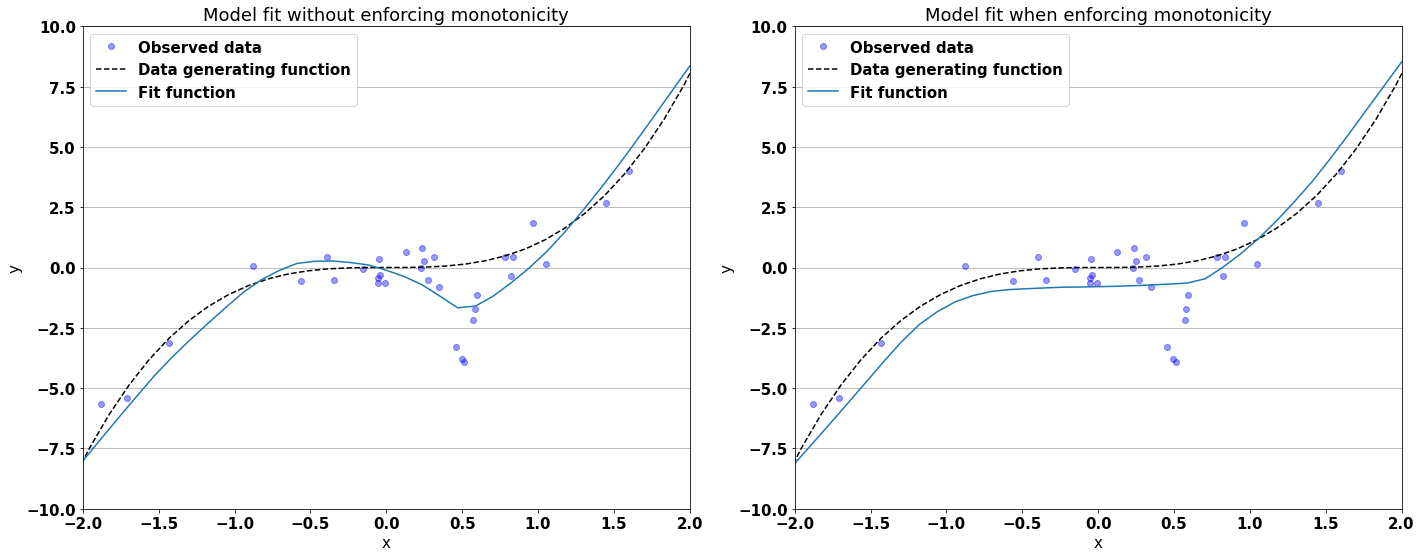

In [17]:

## Training loop

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

figure, ax = plt.subplots(1,2, figsize=(20,8))

for i in range(2):

  my_net = Network(1)
  opt = torch.optim.SGD(my_net.parameters(), lr = lr, momentum = momentum) 
  
  loss_fn = nn.MSELoss() 
  mlloss = monotoneLoss([0], 5)

  for epoch in range(num_epochs):

    tot_train_loss = 0.
    for x,y in train_loader:

      
      my_net.zero_grad()


      ## Add monotone loss function
      if i == 1:
        
        my_net.zero_grad()
        mlloss.calc_loss(my_net, x)
        opt.step()

      out = my_net(x) 
      loss = loss_fn(out,y) 
      loss.backward() 

      opt.step() 
      tot_train_loss = tot_train_loss + x.shape[0]*loss.item() 

    tot_test_loss = 0.0
    for x,y in test_loader:

      
      out = my_net(x) 
      loss = loss_fn(out[:,0],y) 
      tot_test_loss = tot_test_loss + x.shape[0]*loss.item()
    
    tot_train_loss = tot_train_loss / len(train_loader.dataset)
    tot_test_loss = tot_test_loss / len(test_loader.dataset)

    
    print('Epoch: {} Tot train loss: {} Tot test loss: {}'.format(epoch, tot_train_loss, tot_test_loss))

  x_plot = np.linspace(-2,2,num_pts)
  x_plot = (x_plot - x_m)/x_std
  x_plott = torch.from_numpy(x_plot).float()
  x_plott = x_plott.view(-1,1)
  out = my_net(x_plott)
  out = out.detach().numpy()
  out = out*y_std + y_m

  ax[i].plot(X,Y, 'bo', alpha = 0.4, label = 'Observed data')
  ax[i].plot(X_true, Y_true, 'k--', label = 'Data generating function')
  ax[i].plot(x_plot*x_std + x_m, out, label = 'Fit function')


  ax[i].grid(axis = 'y')
  ax[i].set_xlim(-2,2)
  ax[i].set_ylim(-10,10)
  ax[i].legend()
  ax[i].set_xlabel('x')
  ax[i].set_ylabel('y')


  if i == 0:
    ax[i].set_title('Model fit without enforcing monotonicity')
  else:
    ax[i].set_title('Model fit when enforcing monotonicity')

plt.tight_layout()
plt.savefig('monotone_error.png')

In [18]:
from google.colab import files 
files.download('monotone_error.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>